## Predicting Credit Card Payment Default - Ensemble Approach with Classifiers

### In this Analysis we will:

- Using decision trees on a Dataset to make a prediction
- Applying hyper-parameters tuning for decision trees by using RandomGrid 
- Using ensemble algorithms (Random Forest, Adaboost, Extra trees classifier, Gradient Boosted Tree) for predicting payment default.

This dataset is aimed at the case of customer default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients.

In [1]:
#required imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import learning_curve
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#loading the data
dataset = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",skiprows=1)


## Data Exploration

Lets take a look into the dataset.

In [3]:
dataset.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


## Data Preprocessing

#### Renaming the Pay field and splitting the test and training data

In [4]:
dataset = dataset.rename(columns = {'PAY_0':'PAY_1'})

In [5]:
dataset= dataset[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
            'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2',
            'PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default payment next month']].apply(pd.to_numeric)

In [6]:
X_df = dataset.drop("default payment next month", axis = 1)
y_s = dataset["default payment next month"].copy()

In [7]:
X = X_df.values
y = y_s.values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Analysis


#### Building a classifier by using decision tree and calculating the confusion matrix. Trying different hyper-parameters and observe the result.

In [9]:
tree_clf = DecisionTreeClassifier(max_depth=5, criterion='entropy')
dtc = tree_clf.fit(X_train, y_train)

In [10]:
y_dtc = dtc.predict(X_test)

test accuracy for decision tree classifier : 82.68 %


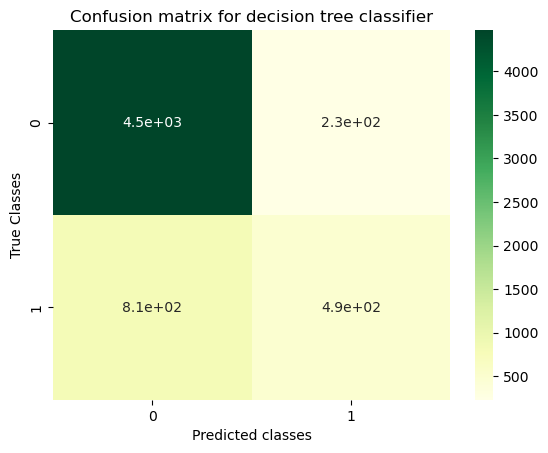

In [11]:
print('test accuracy for decision tree classifier :'\
      , round(accuracy_score(y_test, y_dtc)*100, 2), '%')
plt.title('Confusion matrix for decision tree classifier')
sns.heatmap(confusion_matrix(y_test, y_dtc), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

The accuracy is found to be 82.68%. The confusion matrix also shows the comparison between true and predicted classes.

### Hyperparameter Tuning

#### Running the model with different set of parameters provided manually

In [12]:
tree_clf = DecisionTreeClassifier(max_depth=20, criterion='gini')
dtc = tree_clf.fit(X_train, y_train)

In [13]:
y_dtc = dtc.predict(X_test)

In [14]:
print('test accuracy for decision tree classifier :'\
      , round(accuracy_score(y_test, y_dtc)*100, 2), '%')

test accuracy for decision tree classifier : 76.48 %


Hyperparameters are modified for couple of trials and though it did not show major difference when changed from gini to entropy, there was substantial difference seen with respect to max_depth parameters as accuracy seem to reduce when increasing depth. 

####  Building the decision tree by RandomGrid search over hyper-parameters. 

In [15]:
random_grid = {"max_depth": [3,4,5,10,None],
              "max_features": ["sqrt","log2",None],
              "criterion": ["gini", "entropy"]}

clf = DecisionTreeClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=random_grid,cv=5,n_iter=20)
random_search.fit(X=X_train, y=y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 10, None],
                                        'max_features': ['sqrt', 'log2', None]})

In [16]:
print(random_search.best_params_)
print("\n",random_search.best_estimator_)

{'max_features': None, 'max_depth': 4, 'criterion': 'gini'}

 DecisionTreeClassifier(max_depth=4)


In [17]:
best_rdtc = random_search.best_estimator_

In [18]:
y_rdtc = best_rdtc.predict(X_test)

In [19]:
print('test accuracy for decision tree classifier :'\
      , round(accuracy_score(y_test, y_rdtc)*100, 2), '%')

test accuracy for decision tree classifier : 82.75 %


Random search on decision tree gave accuracy of 82.73%. While manual tuning of hyperparameters gave accuracy of 82.95%.This was slighlty better than using Raindomized search to there difference is not substantial.

#### Building the same classifier by using following ensemble models. 
* Random Forest 
* AdaBoost
* Extra Trees Classifier 
* Gradient Boosted Trees 


In [20]:
rnd_clf = RandomForestClassifier(n_estimators = 10, max_leaf_nodes=16, n_jobs=-1)
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, criterion='entropy'), n_estimators=10,
    algorithm="SAMME.R", learning_rate=0.5)
ext_clf = ExtraTreesClassifier(n_estimators = 10)
gbes_clf = ensemble.GradientBoostingClassifier()

voting_clf = VotingClassifier(
    estimators=[('rfc', rnd_clf), ('adc', ada_clf), ('etc', ext_clf), ('gbc',gbes_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (rnd_clf, ada_clf, ext_clf, gbes_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test);
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred));

RandomForestClassifier 0.82
AdaBoostClassifier 0.8268333333333333
ExtraTreesClassifier 0.8066666666666666
GradientBoostingClassifier 0.828
VotingClassifier 0.8238333333333333


The voting calssifier here did not show any major difference infact Gradient Boositing Classifer was performing slightly better with 82.8% accuracy.

### Learning Curves for Decision Tree and Random Forest Classifers

In [21]:
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(max_depth=4, criterion='entropy'),
X, y,cv=5,scoring='accuracy',train_sizes=np.linspace(0.01, 1.0,5))

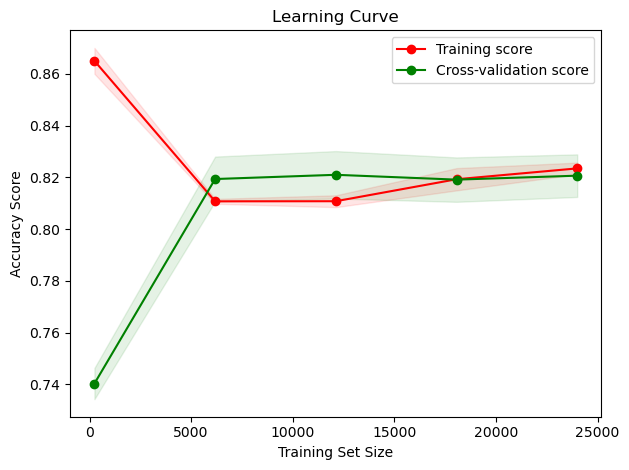

In [22]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, 'o-', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1,color="g")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [23]:
train_sizes, train_scores, test_scores = learning_curve((RandomForestClassifier(n_estimators = 10, max_leaf_nodes=16, n_jobs=-1)),
X, y,cv=5,scoring='accuracy',train_sizes=np.linspace(0.01, 1.0,5))

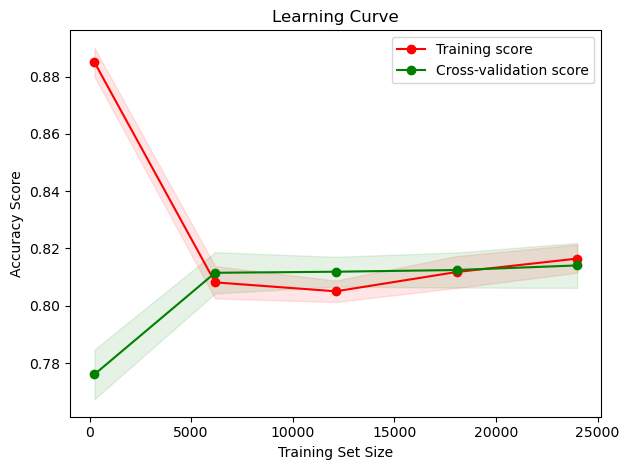

In [24]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, 'o-', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1,color="g")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

The learning curves in both scenarios shows around 82%.

## Observations

In [25]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.30, random_state=0)

In [26]:
tree_clf_1 = DecisionTreeClassifier(max_depth=5, criterion='entropy')
dtc = tree_clf.fit(X_train_1, y_train_1)

In [27]:
y_dtc_1 = dtc.predict(X_test_1)

In [28]:
print('test accuracy for decision tree classifier :'\
      , round(accuracy_score(y_test_1, y_dtc_1)*100, 2), '%')

test accuracy for decision tree classifier : 75.83 %


With change in size of training data, the accuracy has gone down nearly 7%. This shows the model's sensitivity to data and its instability which again is a known weakness.